# Introduction to Machine Learning
### By **[NimbleBox](https://www.nimblebox.ai)**


[<img src="./assets/nbx.jpeg" alt="NimbleBox.ai logo" width="600"/>](https://www.nimblebox.ai)



## What will we learn 
 
Today we will learn about Recurrent Neural Networks and it's types and what exactly it is and what do we use these networks for. We will see in this notebook. Before we directly jump into implementing this we will need to understand some things. Let us see what they are. 


## Recurrent Neural Networks
 
In a recurrent neural network we store the output activations from one or more of the layers of the network. Often these are hidden later activations. Then, the next time we feed an input example to the network, we include the previously-stored outputs as additional inputs. You can think of the additional inputs as being concatenated to the end of the “normal” inputs to the previous layer. For example, if a hidden layer had 10 regular input nodes and 128 hidden nodes in the layer, then it would actually have 138 total inputs (assuming you are feeding the layer’s outputs into itself à la Elman) rather than into another layer). Of course, the very first time you try to compute the output of the network you’ll need to fill in those extra 128 inputs with 0s or something.

<img src="./assets/rnn.png" width=800 />

> Image from [Medium](https://medium.com/ai-journal/lstm-gru-recurrent-neural-networks-81fe2bcdf1f9)

"[A friendly introduction to Recurrent Neural Networks by Luis Serrano](https://www.youtube.com/watch?v=UNmqTiOnRfg)" is one of the best explanation of Recurrent Neural Networks that can give us an in-depth understanding on how these network function.

Now, even though RNNs are quite powerful, they suffer from **Vanishing gradient problem** which hinders them from using long term information, like they are good for storing memory 3-4 instances of past iterations but larger number of instances don't provide good results so we don't just use regular RNNs. Instead, we use a better variation of RNNs: Long Short Term Networks(LSTM).

## What is Vanishing Gradient problem? 
 
Vanishing gradient problem is a difficulty found in training artificial neural networks with gradient-based learning methods and backpropagation. In such methods, each of the neural network's weights receives an update proportional to the partial derivative of the error function with respect to the current weight in each iteration of training. The problem is that in some cases, the gradient will be vanishingly small, effectively preventing the weight from changing its value. In the worst case, this may completely stop the neural network from further training. As one example of the problem cause, traditional activation functions such as the hyperbolic tangent function have gradients in the range (0, 1), and backpropagation computes gradients by the chain rule. This has the effect of multiplying n of these small numbers to compute gradients of the "front" layers in an n-layer network, meaning that the gradient (error signal) decreases exponentially with n while the front layers train very slowly. 
 
<img src="./assets/vgp.png" width=800 />
 
> Image from [Medium](https://medium.com/@anishsingh20/the-vanishing-gradient-problem-48ae7f501257)

## Long Short Term Memory (LSTM) 

Long short-term memory (LSTM) units (or blocks) are a building unit for layers of a recurrent neural network (RNN). A RNN composed of LSTM units is often called an LSTM network. A common LSTM unit is composed of a cell, an input gate, an output gate and a forget gate. The cell is responsible for "remembering" values over arbitrary time intervals; hence the word "memory" in LSTM. Each of the three gates can be thought of as a "conventional" artificial neuron, as in a multi-layer (or feedforward) neural network: that is, they compute an activation (using an activation function) of a weighted sum. Intuitively, they can be thought as regulators of the flow of values that goes through the connections of the LSTM; hence the denotation "gate". There are connections between these gates and the cell.

The expression long short-term refers to the fact that LSTM is a model for the short-term memory which can last for a long period of time. An LSTM is well-suited to classify, process and predict time series given time lags of unknown size and duration between important events. LSTMs were developed to deal with the exploding and vanishing gradient problem when training traditional RNNs. 
 
<img src="./assets/lstm.png" width=800 />
 
> Image from [Medium](https://codeburst.io/generating-text-using-an-lstm-network-no-libraries-2dff88a3968)

## Components of LSTMs

So the LSTM cell contains the following components

* Forget Gate **“f”** ( a neural network with sigmoid)
* Candidate layer **“C"** (a NN with Tanh)
* Input Gate **“I”** ( a NN with sigmoid )
* Output Gate **“O”** ( a NN with sigmoid)
* Hidden state **“H”** ( a vector )
* Memory state **“C”** ( a vector)
* Inputs to the LSTM cell at any step are **Xt** (current input), **Ht-1** (previous hidden state ) and **Ct-1** (previous memory state).
* Outputs from the LSTM cell are **Ht** (current hidden state ) and **Ct** (current memory state)

<img src="./assets/comp.png" width=800 />
 
> Image from [Medium](https://medium.com/deep-math-machine-learning-ai/chapter-10-1-deepnlp-lstm-long-short-term-memory-networks-with-math-21477f8e4235)

## Working of gates in LSTMs

First, LSTM cell takes the previous memory state Ct-1 and does element wise multiplication with forget gate (f) to decide if present memory state Ct. If forget gate value is 0 then previous memory state is completely forgotten else f forget gate value is 1 then previous memory state is completely passed to the cell ( Remember f gate gives values between 0 and 1 ).

**Ct = Ct-1 * ft**

Calculating the new memory state:

**Ct = Ct + (It * Ct)**

Now, we calculate the output:

**Ht = tanh(Ct)**

## Some math behind LSTMs

<img src="./assets/lstm_unit.png">

LSTMs have a separate update gate and forget gate. This clearly makes LSTMs more sophisticated but at the same time more complex as well. There is no simple way to decide which to use for your particular use case. You always have to do trial and error to test the performance.

We would highly suggest to read this [article by Madhu Sanjeevi](https://medium.com/deep-math-machine-learning-ai/chapter-10-1-deepnlp-lstm-long-short-term-memory-networks-with-math-21477f8e4235) for deep dive in the math behind LSTMs.

## Implementation 
 
For this implementation we are going to using LSTMs for predicting the price of stocks of IBM for the year 2017.

In [1]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from tensorflow.keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error

In [2]:
# Some functions to help out with
def plot_predictions(test,predicted):
    plt.plot(test, color='red',label='Real IBM Stock Price')
    plt.plot(predicted, color='blue',label='Predicted IBM Stock Price')
    plt.title('IBM Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('IBM Stock Price')
    plt.legend()
    plt.show()

def return_rmse(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))

In [5]:
# First, we get the data
dataset = pd.read_csv('./assets/data/IBM_2006-01-01_to_2018-01-01.csv', index_col='Date', parse_dates=['Date'])

# Checking for missing values
training_set = dataset[:'2016'].iloc[:,1:2].values
test_set = dataset['2017':].iloc[:,1:2].values

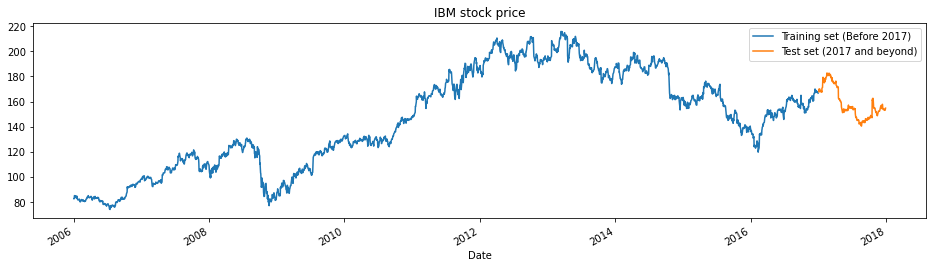

In [6]:
# We have chosen 'High' attribute for prices. Let's see what it looks like
dataset["High"][:'2016'].plot(figsize=(16,4),legend=True)
dataset["High"]['2017':].plot(figsize=(16,4),legend=True)
plt.legend(['Training set (Before 2017)','Test set (2017 and beyond)'])
plt.title('IBM stock price')
plt.show()

In [7]:
# Scaling the training set
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(training_set)

# Since LSTMs store long term memory state, we create a data structure with 60 timesteps and 1 output
# So for each element of training set, we have 60 previous training set elements 
X_train = []
y_train = []
for i in range(60,2769):
    X_train.append(training_set_scaled[i-60:i,0])
    y_train.append(training_set_scaled[i,0])
X_train, y_train = np.array(X_train), np.array(y_train)

# Reshaping X_train for efficient modelling
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

In [8]:
# The LSTM architecture
regressor = Sequential()

# First LSTM layer with Dropout regularisation
regressor.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
regressor.add(Dropout(0.2))

# Second LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))

# Third LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))

# Fourth LSTM layer
regressor.add(LSTM(units=50))
regressor.add(Dropout(0.2))

# The output layer
regressor.add(Dense(units=1))

# Compiling the RNN
regressor.compile(optimizer='rmsprop', loss='mean_squared_error')

# Fitting to the training set
regressor.fit(X_train, y_train, epochs=50, batch_size=32)

Epoch 1/50
85/85 [==============================] - 16s 183ms/step - loss: 0.0274
Epoch 2/50
85/85 [==============================] - 15s 171ms/step - loss: 0.0109
Epoch 3/50
85/85 [==============================] - 15s 172ms/step - loss: 0.0081
Epoch 4/50
85/85 [==============================] - 14s 160ms/step - loss: 0.0070
Epoch 5/50
85/85 [==============================] - 17s 198ms/step - loss: 0.0060
Epoch 6/50
85/85 [==============================] - 21s 253ms/step - loss: 0.0054
Epoch 7/50
85/85 [==============================] - 18s 211ms/step - loss: 0.0052
Epoch 8/50
85/85 [==============================] - 16s 189ms/step - loss: 0.0048
Epoch 9/50
85/85 [==============================] - 21s 243ms/step - loss: 0.0044
Epoch 10/50
85/85 [==============================] - 16s 193ms/step - loss: 0.0041
Epoch 11/50
85/85 [==============================] - 12s 143ms/step - loss: 0.0039
Epoch 12/50
85/85 [==============================] - 16s 189ms/step - loss: 0.0034
Epoch 13/50
8

Now that our model has trained, let us try to predict the stock prices of IBM in 2017

In [9]:
# Now to get the test set ready in a similar way as the training set.
# The following has been done so forst 60 entires of test set have 60 previous values which is impossible to get unless we take the whole 
# 'High' attribute data for processing
dataset_total = pd.concat((dataset["High"][:'2016'],dataset["High"]['2017':]),axis=0)
inputs = dataset_total[len(dataset_total)-len(test_set) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = sc.transform(inputs)

# Preparing X_test and predicting the prices
X_test = []
for i in range(60,311):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

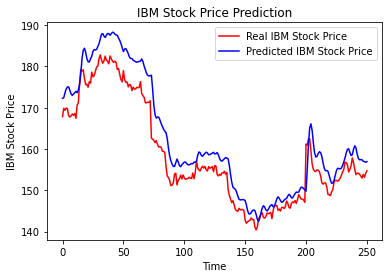

In [10]:
# Visualizing the results for LSTM
plot_predictions(test_set,predicted_stock_price)

In [11]:
# Evaluating our model
return_rmse(test_set,predicted_stock_price)

The root mean squared error is 4.85832851195862.


LSTM is not the only kind of unit that has taken the world of Deep Learning by a storm. We have **Gated Recurrent Units (GRU)**. It's not known, which is better: GRU or LSTM becuase they have comparable performances. GRUs are easier to train than LSTMs.

## Gated Recurrent Units (GRUs)

The GRU unit does not have to use a memory unit to control the flow of information like the LSTM unit. It can directly makes use of the all hidden states without any control. GRUs have fewer parameters and thus may train a bit faster or need less data to generalize. But, with large data, the LSTMs with higher expressiveness may lead to better results.

They are almost similar to LSTMs except that they have two gates: reset gate and update gate. Reset gate determines how to combine new input to previous memory and update gate determines how much of the previous state to keep. Update gate in GRU is what input gate and forget gate were in LSTM. We don't have the second non linearity in GRU before calculating the output neither they have the output gate.

**Understanding GRU with Math**

<img src="./assets/gru.png" width=800 />
 
> Image from [Medium](https://medium.com/@saurabh.rathor092/simple-rnn-vs-gru-vs-lstm-difference-lies-in-more-flexible-control-5f33e07b1e57)

## Implementation

Let us now see how we can use GRU to predict the price of stocks of IBM for the year 2017.

In [12]:
# The GRU architecture
regressorGRU = Sequential()

# First GRU layer with Dropout regularisation
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))

# Second GRU layer
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))

# Third GRU layer
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))

# Fourth GRU layer
regressorGRU.add(GRU(units=50, activation='tanh'))
regressorGRU.add(Dropout(0.2))

# The output layer
regressorGRU.add(Dense(units=1))

# Compiling the RNN
regressorGRU.compile(optimizer=SGD(lr=0.01, decay=1e-7, momentum=0.9, nesterov=False),loss='mean_squared_error')

# Fitting to the training set
regressorGRU.fit(X_train,y_train,epochs=50,batch_size=150)

Epoch 1/50
19/19 [==============================] - 6s 291ms/step - loss: 0.1191
Epoch 2/50
19/19 [==============================] - 6s 322ms/step - loss: 0.0352
Epoch 3/50
19/19 [==============================] - 6s 326ms/step - loss: 0.0087
Epoch 4/50
19/19 [==============================] - 5s 284ms/step - loss: 0.0049
Epoch 5/50
19/19 [==============================] - 6s 312ms/step - loss: 0.0044
Epoch 6/50
19/19 [==============================] - 6s 342ms/step - loss: 0.0040
Epoch 7/50
19/19 [==============================] - 6s 297ms/step - loss: 0.0036
Epoch 8/50
19/19 [==============================] - 6s 305ms/step - loss: 0.0035
Epoch 9/50
19/19 [==============================] - 6s 293ms/step - loss: 0.0033
Epoch 10/50
19/19 [==============================] - 6s 301ms/step - loss: 0.0034
Epoch 11/50
19/19 [==============================] - 8s 403ms/step - loss: 0.0032
Epoch 12/50
19/19 [==============================] - 5s 279ms/step - loss: 0.0032
Epoch 13/50
19/19 [======

In [13]:
# Preparing X_test and predicting the prices
X_test = []
for i in range(60,311):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
GRU_predicted_stock_price = regressorGRU.predict(X_test)
GRU_predicted_stock_price = sc.inverse_transform(GRU_predicted_stock_price)

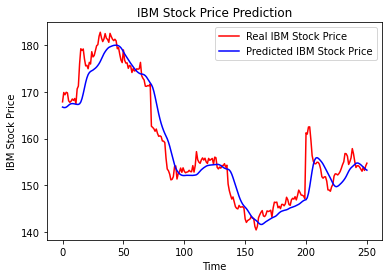

In [14]:
# Visualizing the results for GRU
plot_predictions(test_set,GRU_predicted_stock_price)

In [15]:
# Evaluating GRU
return_rmse(test_set,GRU_predicted_stock_price)

The root mean squared error is 3.4439560044139252.


## Conclusion

To sum this up, RNN’s are good for processing sequence data for predictions but suffers from short-term memory. LSTM’s and GRU’s were created as a method to mitigate short-term memory using mechanisms called gates. Gates are just neural networks that regulate the flow of information flowing through the sequence chain. LSTM’s and GRU’s are used in state of the art deep learning applications like speech recognition, speech synthesis, natural language understanding, etc.